### This notebook shows example usage of the PyTICS algorithm for NGC 3783 taken with ten LCO 1-m telescopes for the u band 
### The main github page has attached the paper on the algorithm (Vieliute et al. submitted to MNRAS)
### PyTICS will soon be available as a public access package allowing for easy intercalibration of photometric data with a couple lines of code as shown below

In [ ]:
# -------------- Import packages --------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import pickle
import arx
import time
from scipy.optimize import curve_fit
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.interpolate import interp1d
from scipy.stats import linregress

# ------- Import star data in pickle format -------
lco = pd.read_pickle('lco_latest_stan.pkl')

# -------------- Obs info --------------
#AGN Name
obj_name = 'NGC3783'

#FILTERS = pd.unique(lco['Filter']) #not in order
FILTERS = ['up', 'B', 'gp', 'V', 'rp', 'ip', 'zs', 'Y'] #in order
print('FILTERS:', FILTERS)

TEL = list(pd.unique(lco['telid']))
print('SCOPES:', TEL)

AGN_ID = 2387

In [4]:
# ===================================== Function Library ============================================
def Clean(Star_File):
    """ Drop duplicate values, existing zp and zp_err columns, and strange errors (= 99.0).
    
    Input:
    Star_File - Original data file (pd dataframe).
    
    Output:
    File2 - Cleaned up data file (pd dataframe).
    """
    
    File2 = Star_File.drop(columns = ["zp", "zp_err"])
    File2 = File2.drop_duplicates(subset=['id_apass', 'Filter', 'MJD', 'corr_aper', 'telid', 'airmass', 'seeing'], keep='first', inplace=False, ignore_index=False)
    File2 = File2.drop(File2[(File2['err_aper'] > 20)].index)
    return(File2)
    
def Locate_Star_ID(Star_File, Star_ID):
    """ Locate star(s) in the file by ID(s).
    
    Input:
    Star_File - Star data (pd dataframe).
    Star_ID - Star ID(s) (float or list).
    
    Output:
    Stars - pd dataframe containing selected stars by ID.
    """
    if type(Star_ID) == list:
        mask = Star_File['id_apass'].isin(Star_ID)
        Stars = Star_File[mask]
    else:
        Stars = Star_File.loc[Star_File['id_apass'] == Star_ID]
    return(Stars)

def Locate_Star_Filter(Star_File, Fltr):
    """ Locate star(s) in the file by filter(s).
    
    Input:
    Star_File - Star data (pd dataframe).
    Fltr - Filter(s) (string or list).
    
    Output:
    Stars - pd dataframe containing selected stars by filter.
    """
    if type(Fltr) == list:
        mask = Star_File['Filter'].isin(Fltr)
        Stars = Star_File[mask]
    else:
        Stars = Star_File.loc[Star_File['Filter'] == Fltr] 
    return(Stars)

def Locate_Star_Scope(Star_File, Telescope):
    """ Locate star(s) in the file by telescope(s).
    
    Input:
    Star_File - Star data (pd dataframe).
    Telescope - Telescope(s) (string or list).
    
    Output:
    Stars - pd dataframe containing selected stars by telescope.
    """
    if type(Telescope) == list:
        mask = Star_File['telid'].isin(Telescope)
        Stars = Star_File[mask]
    else:
        Stars = Star_File.loc[Star_File['telid'] == Telescope]
    return(Stars)

def Locate_Star_Epoch(Star_File, Epoch):
    """ Locate star(s) in the file by Epoch(s).
    
    Input:
    Star_File - Star data (pd dataframe).
    Epoch - MJD(s) (string or list).
    
    Output:
    Stars - pd dataframe containing selected stars by epoch.
    """
    if type(Epoch) == list:
        mask = Star_File['MJD'].isin(Epoch)
        Stars = Star_File[mask]
    else:
        Stars = Star_File.loc[Star_File['MJD'] == Epoch]
    return(Stars)

def Generic_Optimal(Data, Errors):
    """ Compute inverse variance weighted average.
    
    Input:
    Data - Data to average (list/array).
    Errors - Errors of data to average (list/array).
    
    Output:
    avg - Optimal average (float).
    err - standard deviation of average (float).
    """
    
    #errors handled by returning nan values
    #ensure data are in arrays
    var = np.array(Errors)**2
    Data = np.array(Data)
    
    if len(var) != 0:
        try:
            w = 1/var
            avg = np.nansum(w*Data) / np.nansum(w)
            var = 1/np.nansum(w)
        except:
            avg = np.nan
            var = np.nan
    else:
        avg = np.nan
        var = np.nan
    
    if var**0.5 == np.inf:
        var == np.nan
        avg == np.nan
    
    err = var**0.5
    return(avg, err)

def Brightest(Star_File, Filter, AGN_ID = AGN_ID):
    """ IDs of the brghtest stars in the data for a specific filter, identified using optimal average. 
    
    Input:
    Star_File - Star data (pd dataframe).
    Filter - Filter (string).
    AGN_ID - ID of AGN (int).
    
    Output:
    Brightest_IDs - IDs of stars sorted from brightest to dimmest (list).
    """
    
    #Select specified filter data
    Star_Data0 = Locate_Star_Filter(Star_File, Filter)
    
    #Make sure AGN isn't included
    Star_IDs = [k for k in pd.unique(Star_Data0['id_apass']) if k!= AGN_ID]

    #Compute optimal average of instrumental magnitudes
    MAGS = []
    IDS = []
    for ID in Star_IDs:
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        mag = Star_Data['mag_aper'].values
        mag_err = Star_Data['err_aper'].values
        mag_mean = Generic_Optimal(mag, mag_err)[0]
        MAGS.append(mag_mean)
        IDS.append(ID)
    
    #Sort from brightest to dimmest and return IDs
    MAGS_ref = MAGS
    MAGS = sorted(MAGS)
    Brightest_indices = [MAGS_ref.index(i) for i in MAGS]
    Brightest_IDs = np.array(IDS)[np.array(Brightest_indices)]
    return Brightest_IDs

def root_mean_squared_deviation(data, mean):
    """Compute rms of dataset.
    Input:
    data - dataset to compute rms for (array/list).
    mean - mean of dataset (float).
    
    Output:
    rms - root mean squared deviation (float).
    """
    
    rms = (sum((data-mean)**2) / (len(data) - 1))**0.5
    return(rms)

def Brightest_Reduced(Star_File, Filter, AGN_ID = AGN_ID, frac = 0.5):
    """ IDs of the brightest stars in the data for a specific filter, identified using optimal average. 
        Only include stars that have more than specified number of data points per star.
    
    Input:
    Star_File - Star data (pd dataframe).
    Filter - Filter (string).
    AGN_ID - ID of AGN (int).
    frac - (Optional) Fraction of max number of epochs to keep (float).
    
    Output:
    Brightest_IDs - IDs of stars sorted from brightest to dimmest (list).
    """
    
    #Select specified filter data
    Star_Data0 = Locate_Star_Filter(Star_File, Filter)
    
    #Make sure AGN isn't included
    Star_IDs = [k for k in pd.unique(Star_Data0['id_apass']) if k!= AGN_ID]
    
    Max_length = 0.0  
    #Get max number of epochs amongst all stars
    for ID in Star_IDs:
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        if len(Star_Data['MJD'].values) > Max_length:
            Max_length = len(Star_Data['MJD'].values)
    
    #Select all stars with more than specified number of datapoints
    keep_dp = frac * Max_length
    Reduced_IDs = []
    for ID in Star_IDs:     
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        if len(Star_Data['MJD'].values) > keep_dp:
            Reduced_IDs.append(ID)
    
    #Compute optimal average of instrumental magnitudes
    MAGS = []
    IDS = []
    for ID in Reduced_IDs:
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        mag = Star_Data['mag_aper'].values
        mag_err = Star_Data['err_aper'].values
        mag_mean = Generic_Optimal(mag, mag_err)[0]
        MAGS.append(mag_mean)
        IDS.append(ID)
    
    #Sort from brightest to dimmest and return IDs
    MAGS_ref = MAGS
    MAGS = sorted(MAGS)
    Brightest_indices = [MAGS_ref.index(i) for i in MAGS]
    Brightest_IDs = list(np.array(IDS)[np.array(Brightest_indices)])
    return Brightest_IDs

def Epoch_Dist(Star_File, Filter, AGN_ID = AGN_ID, frac = 0.0):
    """ Display distribution of stars by number of epochs per star.
        Include how many stars are available with at least a certain fraction of the max number of epochs.
        Also show the instrumental magnitude of stars as a function of the number of epochs.
        
    Input:
    Star_File - Star data (pd dataframe).
    Filter - Filter (string).
    frac - (optional) print number of stars available with at least this fraction of the max number of epochs.
    """
    
    #Select specified filter data
    Star_Data0 = Locate_Star_Filter(Star_File, Filter)
    
    #Make sure AGN isn't included
    Star_IDs = [k for k in pd.unique(Star_Data0['id_apass']) if k!= AGN_ID]
    
    #Count number of epochs for each star and mean instrumental mags
    Lengths = []
    Mags = []
    for ID in Star_IDs:
        Star_Data = Locate_Star_ID(Star_Data0, ID)
        Lengths.append(len(Star_Data['MJD'].values))
        Mags.append(Generic_Optimal(Star_Data.mag_aper.values, Star_Data.err_aper.values)[0])
    Lengths = np.array(Lengths)
    
    # --------------- Plot data ----------------
    fig, (ax, axb) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 2]}, figsize = (16, 6))
    fig.subplots_adjust(wspace = 0.4)
    nbins = 40
    hist0 = ax.hist(Lengths, bins = nbins, weights=np.ones(len(Lengths)) / len(Lengths))
    ax.cla()
    hist = ax.hist(Lengths, bins = nbins, color = 'gray', alpha = 0.7, zorder = 10, edgecolor = None, weights=np.ones(len(Lengths)) / max(hist0[0]) / len(Lengths))

    #CDF
    X0 = sorted(list(np.arange(min(Lengths), max(Lengths) + math.floor((max(Lengths) - min(Lengths)) / nbins), (max(Lengths) - min(Lengths)) / nbins)) * 2)[:-1]

    N = [0.]
    for i in hist0[0]:
        N.append(i+N[-1])
    N = sorted(N*2)[1:]

    X = sorted(X0)
    ax.plot(X, N, color = 'black', zorder = 20, lw = 1.0)
    
    #Number of Stars Available
    labs = []
    X2 = []
    N2 = []
    for j in np.arange(1.0, -0.1, -0.01):
        j = round(j, 3)
        X2.append(j*max(Lengths))
        N2.append(len([k for k in Lengths if k > j*max(Lengths)]) / len(Lengths))
        labs.append(str(len([k for k in Lengths if k > j*max(Lengths)])))
    N2 = sorted(N2*2)[1:]
    X2 = sorted(X2*2)[1:] ; X2 = sorted(X2, reverse = True)

    
    ax.plot(X2, N2, color = 'Teal', zorder = 20, lw = 1.0)
    
    # ------- Formatting -------
    ax.set_title(str(Filter) + ' Filter')    
    ax.set_xlabel('Number of Epochs', fontsize = 15)
    ax.set_ylabel('# of Stars Available with at least M datapoints \n M = Frac x max # of Epochs', color = 'Teal', fontsize = 15)
    ax.set_xlim(0, max(Lengths))

    """
    #nicer ticks test
    m = 10**(len(str(max(Lengths))) - 1)
    if max(Lengths) < 1000:
        ax.set_xticks(np.arange(0, math.ceil(max(Lengths) / m) * m, 100))
    elif max(Lengths) < 2500:
        ax.set_xticks(np.arange(0, math.ceil(max(Lengths) / m) * m, 250))
    else:
        ax.set_xticks(np.arange(0, math.ceil(max(Lengths) / m) * m, 500))
    """
    
    ax.set_ylim(0, 1.01)
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.set_yticklabels([round(i) for i in np.arange(0, len(Lengths)+len(Lengths)/11, 0.1*len(Lengths))], color = 'Teal')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax.minorticks_on()
    
    ax2 = ax.twinx()
    ax2.plot(X, N, alpha = 0)
    ax2.set_ylim(0, 1.01)
    ax2.set_yticks(np.arange(0, 1.1, 0.1))
    ax2.set_yticklabels([round(j, 2) for j in np.arange(0, 1.1, 0.1)], color = 'black')
    ax2.set_ylabel('CDF', color = 'black', fontsize = 15)
    ax2.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax2.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax2.minorticks_on()
    
    ax3 = ax.twiny()
    ax3.vlines(np.arange(0,1.05,0.1), 0, 1,color = 'teal', lw = 0.8, ls = '--', alpha = 0.2, zorder = 0)
    ax3.vlines(np.arange(0,1.05,0.05), 0, 1,color = 'teal', lw = 0.5, ls = '--', alpha = 0.2, zorder = 0)
    ax3.hlines(np.arange(0,1.05,0.1), 0, 1,color = 'teal', lw = 0.8, ls = '--', alpha = 0.2, zorder = 0)
    ax3.hlines(np.arange(0,1.05,0.05), 0, 1,color = 'teal', lw = 0.5, ls = '--', alpha = 0.2, zorder = 0)
    ax3.set_xticks(np.arange(0, 1.1, 0.1))
    ax3.set_xticklabels([round(j, 2) for j in np.arange(0, 1.1, 0.1)], color = 'Teal')
    ax3.plot(X, N, alpha = 0)
    ax3.set_xlim(0, 1.01)
    ax3.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax3.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax3.minorticks_on()
    ax3.set_xlabel('Frac', color = 'Teal', fontsize = 15)
        
    axb.scatter(Lengths, Mags, color = 'orange')
    axb.set_xlabel('Number of Epochs', fontsize = 15)
    axb.set_ylabel('Mean Instrumental Mag', fontsize = 15)
    axb.invert_yaxis()
    axb.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    axb.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    axb.minorticks_on()
    
    if frac == 0.0:
        print('============================== ',str(Filter), 'Filter  ==============================')
        print('Total number of stars available: ', len(Lengths))
        print('Max number of epochs amongst all stars:', max(Lengths))
    else:
        print('============================== ',str(Filter), 'Filter  ==============================')
        print('Total number of stars available: ', len(Lengths))
        print('Max number of epochs amongst all stars:', max(Lengths))
        print('Number of stars available with more than ' + str(frac)+' of the max number of epochs: '+str(len([k for k in Lengths if k > frac*max(Lengths)])) )

def Detect_Var(Star_File, Filter, Lim = None, High = [], Label = False, Log = True, TEL = TEL, AGN_ID = AGN_ID, ww = 0.2, bww = 1.0):
    """Display rms vs mag plot to identify variable stars.

    Input:
    Star_File - Calibrated star dataframe (pd dataframe).
    Filter - Filter (string).
    Star_File_All (Optional) - If you want to specify your own star IDs to use in the calibration, rather than selecting the brightest ones (list/array)
    Lim - (Optional) If doing a fit, select limit below which mag stars are fitted. If no Lim, all stars will be fitted. (float)
    High - (Optional) Star IDs to highlight (list)
    Label - (Optional) If True, all star IDs will be displayed on the plot, to visually identify certain stars (bool)
    Log - (Optional) turn plot into log-log plot (bool)
    
    """

    #Make sure correct filter data is selected
    Star_File = Locate_Star_Filter(Star_File, Filter)

    #Set up figure
    fig, (ax, ax2) = plt.subplots(1,2, figsize = (12,6), sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    #Put data on log plot if wanted
    if Log == True:
        ax.set_yscale('log')
        ax2.set_yscale('log')

    #Set plot titles
    ax.set_title(r'RMS = $(\frac{ΣV_{i}}{N} + V_{X})^{0.5}$     ' + Filter + ' Filter', size = 20)
    ax2.set_title(r'RMS = $(\frac{Σ(m_{i} - <M(*)>)^{2}}{N - 1})^{0.5}}$     ' + Filter + ' Filter', size = 20)
    
    Star_IDs = pd.unique(Star_File['id_apass'])
    
    cond = False ; cond2 = False
    Len_Lim = 300
    
    all_mags = []
    all_rms = [] ; all_rms_err = []
    
    all_rms2 = []
    
    for ID in Star_IDs:
        dat2 = Locate_Star_ID(Star_File, ID)
        if len(dat2) > 0:
            mags2 = dat2['m_star'].values[0]
            mags_err2 = dat2['m_star_err'].values[0]            
            
            rms = root_mean_squared_deviation(dat2['mag_aper'], dat2['m_star'])
            rms_star = ((np.sum(dat2.err_aper.values**2) / len(dat2)) + dat2.rms_star.values[0]**2)**0.5

            if ID == Star_IDs[0]:
                lab1 = 'using max 100 stars'
            else:
                lab1 = None

            #If ID's were specified in High argument, they will appear as bright pink markers
            if ID in High:
                ax.scatter(mags2, rms_star, color = 'deeppink', s = 25, marker = 'x', zorder = 10)
                ax2.scatter(mags2, rms, color = 'deeppink', s = 25, marker = 'x', zorder = 10)
            else:
                ax.scatter(mags2, rms_star, color = 'blue', s = 5, label = lab1, zorder = 10, alpha = 0.7)
                ax2.scatter(mags2, rms, color = 'blue', s = 5, label = lab1, zorder = 10, alpha = 0.7)

            all_mags.append(dat2['m_star'].values[0])
            all_rms.append(rms_star)
            all_rms_err.append(dat2['rms_star_err'].values[0])

        ax.legend(loc = 'upper left')
        ax2.legend(loc = 'upper left')

        
        #Add star IDs next to data points if wanted
        if Label == True:
            if Log == True:
                if ID in High:
                    t = ax.text(mags2, rms_star, str(ID), rotation = 0, color = 'deeppink', alpha = 1.0, size = 10, zorder = 10, weight = 'bold')
                else:
                    ax.text(mags2, rms_star, str(ID), rotation = 90, color = 'black', alpha = 0.5, size = 8)
            else:
                if ID in High:
                    t = ax.text(mags2 - 0.05, rms_star + 0.003, str(ID), rotation = 0, color = 'deeppink', alpha = 1.0, size = 10, zorder = 10, weight = 'bold')                        
                else:
                    ax.text(mags2 - 0.05, rms_star + 0.003, str(ID), rotation = 90, color = 'black', alpha = 0.5, size = 8)

    #ax3.hlines(0, -20, len(Star_IDs)+20, color = 'black', lw = .8, zorder = 0, ls = '--')
    #ax3.set_xlim(-5, len(Star_IDs)+5)
    all_mags_sorted = np.array(sorted([i for i in all_mags if i > Lim]))
    all_mags_ind = np.array([all_mags.index(i) for i in all_mags_sorted])
    all_rms_sorted = np.array([all_rms[i] for i in all_mags_ind])
    all_rms_sorted_err = np.array([all_rms_err[i] for i in all_mags_ind])

    ax.set_xlabel('Mean Instrumental Magnitude')
    ax2.set_xlabel('Mean Instrumental Magnitude')
    ax.set_ylabel('RMS')
    #ax2.set_ylabel('RMS')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax.minorticks_on()
    ax2.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax2.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax2.minorticks_on()
    #ax.set_ylim(10**(-3), 10**(0))
    ax.legend()


def Plot_LC(Star_Data, Filter, TEL = TEL, err_th = 0.05, Stars = []):
    """Plot calibrated star lightcurves and total error distribution.
       Remove outliers based on a double outlier detection method and inspect cleaned lightcurves.
    
    Input:
    Star_Data - Calibrated star dataframe (pd dataframe).
    Filter - Filter (string).
    err_th - (Optional) Error threshold for clipping outliers.
    Stars - (Optional) If you don't wish to plot aLL the lightcurves for all the stars in the file, input IDs of stars you do want to see (list/array).
    """
    #COLORS = ['#E9967A', '#FFB6C1', '#8FBC8F', '#DDA0DD', '#6495ED', '#FFD700', '#008080', '#FF4500', '#8A2BE2', '#008B45']#['#FFA07A', '#FFC0CB', '#98FB98', '#D8BFD8', '#87CEEB', '#FFD700', '#20B2AA', '#FF6347', '#9370DB', '#00FA9A']
    import random
    COLORS = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in range(len(TEL))]

    font = 'Cambria'
    if len(Stars) > 0:
        #Selecting only inputed stars
        Star_IDs = Stars
    else:
        #All stars in dataframe
        Star_IDs = pd.unique(Star_Data['id_apass'])
    
    for ID in Star_IDs:
        #set up figure
        T_no = len(TEL)
        num_of_plots = (T_no - 1) // 5 + 1
        if len(TEL) < 5:
            fig0, ax0 = plt.subplots(num_of_plots, len(TEL), sharex = False, figsize = (15, 2.5*num_of_plots))
            ax0 = ax0.reshape(1, len(TEL))
        else:
            fig0, ax0 = plt.subplots(num_of_plots, 5, sharex = False, figsize = (15, 2.5*num_of_plots))
        
        fig0.subplots_adjust(wspace=0.1, hspace = 0.4)
        r = 0
        c = 0
        
        #older MAD method
        #scope_mad = []
        
        for scope in TEL:
            #Select data for particular telescope
            dat = Locate_Star_ID(Locate_Star_Scope(Star_Data, scope), ID)
            err = dat.err_tot
                        
            if len(dat) > 0:
                nbins = int(0.8*len(err))
                if nbins == 0:
                    nbins = 1
                hist = ax0[r, c].hist(err, bins = nbins, alpha = 0.7, density = False, color = COLORS[TEL.index(scope)])
                ax0[r, c].vlines(err_th, 0, max(hist[0]), lw = 1.2, ls = '--', color = 'red', label = 'Outlier Threshold')
                
                #older MAD method
                #MAD = np.sum(abs(err - np.median(err))) / len(err)
                #ax0[r, c].axvspan(np.median(err) - MAD, np.median(err) + MAD, alpha=0.1, color='red',label = 'MAD')
                #ax0[r, c].axvspan(np.median(err) - 2*MAD, np.median(err) + 2*MAD, alpha=0.1, color='orange',label = '2*MAD')
                
                ax0[r, c].legend()
                ax0[r, c].tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
                ax0[r, c].tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
                ax0[r, c].minorticks_on()
                ax0[r, c].set_xlabel('Total error')
            ax0[r, c].set_title('Star ' + str(ID) + '\n'+ str(scope) +'\n No. of datapoints: ' + str(len(dat)), fontsize = 10)

            if c < 4:
                c = c + 1
            else:
                r = r + 1
                c = 0
            #older mad method
            #scope_mad.append(MAD)

        fig, ax4 = plt.subplots(3,1, figsize = (16, 9), sharex = True)
        #fig2, ax4 = plt.subplots(3,1, figsize = (19, 14))
        
        fig.subplots_adjust(hspace = 0)
        #fig2.subplots_adjust(hspace = 0.)

        ax4[1].set_ylabel('Inst. Mag', fontproperties = font, size = 15)
        ax4[2].set_ylabel('Inst. Mag', fontproperties = font, size = 15)
        ax4[2].set_xlabel('MJD', fontproperties = font, size = 15)

        tot_dat = 0.
        clipped = 0.
        for scope in TEL:
            #Select data based on particular telescope
            dat = Locate_Star_Scope(Locate_Star_Filter(Locate_Star_ID(Star_Data, ID), Filter), scope)
            lcodat = Locate_Star_Scope(Locate_Star_Filter(Locate_Star_ID(lco2, ID), Filter), scope)

            if len(dat) > 0:
                #older mad method
                #con1 = (dat['err_tot'] > np.median(dat['err_tot']) + scope_mad[TEL.index(scope)])

                #First outlier detection method based on specified threshold
                con1 = (dat['err_tot'] > err_th)
                #Secondary outlier detection method based on deviation from mean
                con2 = (abs(dat['m_star'] - dat['mag_aper']) > 3*dat['err_tot'])
                outliers = np.where(np.logical_or(con1,con2))[0]
                not_outliers = [j for j in np.arange(0, len(dat), 1) if j not in outliers]

                dat2a = dat.iloc[outliers]
                dat2b = dat.iloc[not_outliers]
                tot_dat = tot_dat + len(dat)
                clipped = clipped + len(outliers)

                ax4[1].scatter(dat2a['MJD'].values, dat2a['mag_aper'].values, color = 'red', s = 30, marker = 'x', zorder = 10, alpha = 1.0, linewidths=1.3)
                label = scope

                Data = Locate_Star_Scope(dat, scope)
                ax4[2].scatter(dat2b['MJD'].values, dat2b['mag_aper'].values, s = 20, zorder = 10, label = label, color = COLORS[TEL.index(scope)])
                ax4[2].errorbar(dat2b['MJD'].values, dat2b['mag_aper'].values, yerr = dat2b['err_tot'].values,ls = 'none', color = COLORS[TEL.index(scope)], lw = 0.5)
                ax4[1].errorbar(dat['MJD'].values, dat['mag_aper'].values, yerr = (dat['err_aper'].values**2 + dat['rms_sc'].values**2 + dat['rms_t'].values**2 + dat['rms_star'].values**2)**0.5, ls = 'none', color = COLORS[TEL.index(scope)], lw = 0.5)
                ax4[1].scatter(dat['MJD'].values, dat['mag_aper'].values, s = 20, label = label, color = COLORS[TEL.index(scope)])
                
                ax4[0].errorbar(lcodat.MJD, lcodat.mag_aper,yerr = lcodat.err_aper, ls = 'none', color = COLORS[TEL.index(scope)], lw = 0.5)
                ax4[0].scatter(lcodat.MJD, lcodat.mag_aper, s = 14,label = label, color = COLORS[TEL.index(scope)] )
                
                #ax4[1].set_ylim(-5.8, -6.3)
                #ax4[2].set_ylim(max(dat2b['mag_aper'].values) - max(dat2b['mag_aper'].values) / 5, min(dat2b['mag_aper'].values) + min(dat2b['mag_aper'].values) / 5)

                #ax5.set_title('Uncalibrated Star Lightcurve', fontproperties = font, size = 20)
                if scope == TEL[0]:
                    lab = 'm(*) + dmags + dmagt'
                else:
                    lab = None
                #ax5.scatter(dat.MJD, dat.m_star + dat.DMAGS + dat.DMAGT, s = 14, color = 'black' , marker = 'x',lw = 0.8, label = lab)
                #ax5.errorbar(dat.MJD, dat.m_star + dat.DMAGS + dat.DMAGT,yerr = dat.err_tot, ls = 'none', color = 'black',lw = 0.8)
        ax4[0].legend()

                
        Data = Locate_Star_ID(Star_Data, ID)
        ax4[1].hlines(Data['m_star'].values[0], min(Data['MJD'].values), max(Data['MJD'].values), lw = 1, ls = '--', label = 'Star: ' + str(ID))
        ax4[1].legend(loc='center right')
        ax4[1].invert_yaxis()
        ax4[1].tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
        ax4[1].tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
        ax4[1].minorticks_on()
        ax4[1].set_title('Star ' + str(ID) + '  |  Datapoints Clipped: '+str(int(clipped))+' out of '+str(int(tot_dat)))
        ax4[2].hlines(Data['m_star'].values[0], min(Data['MJD'].values), max(Data['MJD'].values), lw = 1, ls = '--', label = 'Star: ' + str(ID))
        ax4[2].legend(loc='center right')
        ax4[2].invert_yaxis()
        ax4[2].tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
        ax4[2].tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
        ax4[2].minorticks_on()
        #ax4[1].set_ylim(max(Data.mag_aper) + 0.05, min(Data.mag_aper) - 0.05)
        #ax4[2].set_ylim(max(Data.mag_aper) + 0.05, min(Data.mag_aper) - 0.05)
        ax4[1].set_xticks(np.arange(int(min(Data.MJD)), int(max(Data.MJD)), 100), labels = np.arange(int(min(Data.MJD)), int(max(Data.MJD)), 100), fontproperties = font, size = 15)
        ax4[2].set_xticks(np.arange(int(min(Data.MJD)), int(max(Data.MJD)), 100), labels = np.arange(int(min(Data.MJD)), int(max(Data.MJD)), 100), fontproperties = font, size = 15)

        #ax4[0].set_title('Example Uncalibrated Star Lightcurve in U band (Star 2344)', fontproperties = font, size = 15)
        ax4[0].legend(loc='center right')
        ax4[0].invert_yaxis()
        ax4[0].tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
        ax4[0].tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
        ax4[0].minorticks_on()
        ax4[0].set_ylabel('Inst. Mag', fontproperties = font, size = 15)
        ax4[0].set_xlabel('MJD', fontproperties = font, size = 15)
        ax4[0].set_xticks(np.arange(int(min(Data.MJD)), int(max(Data.MJD) + 100), 100), labels = np.arange(int(min(Data.MJD)), int(max(Data.MJD) + 100), 100), fontproperties = font, size = 15)
        #ax5.set_yticks(np.arange(int(max(Data.mag_aper)), int(min(Data.mag_aper)), 1), labels = np.arange(int(max(Data.mag_aper)), int(min(Data.mag_aper)), 1), fontproperties = font, size = 15)

def AGN_LC(Original_Star_File, Star_Data, Filter, unit = 'mag', err_th = 0.05, Plot = True, Rem_out = True, AGN_ID = AGN_ID, TEL = TEL, zp = [0.,0.]):
    """ Return Dataframe with calibrated AGN Lightcurve. Choose whether to leave in outliers.
        Can also plot the AGN lightcurve.
    
    Input:
    Original_Star_File - Original lco file (pd dataframe).
    Star_Data - Calibrated star dataframe (pd dataframe).
    Filter - Filter (string).
    err_th - (Optional) Error threshold for clipping outliers.
    Plot - (Optional) Choose whether to display the error distributions and lightcurves (Bool).
    Rem_out = (Optional) Choose whether to remove outliers from returned AGN dataframe (Bool). 
    
    Output:
    AGN_DF - dataframe containing calibrated AGN lightcurve.
   """
    
    #Set up dataframe
    columns = ['Filter','telid', 'MJD', 'mag', 'err', 'err_sys']
    AGN_DF = pd.DataFrame(columns=columns)
    font = 'Cambria'
    AGN_Data = Locate_Star_ID(Locate_Star_Filter(Original_Star_File, Filter), AGN_ID)
    for scope in TEL:
        #Select data based on telescope
        AGN_Data2 = Locate_Star_Scope(AGN_Data, scope)
        for E in pd.unique(AGN_Data2['MJD']):
            
            #Select data based on Epoch
            AGN_Data3 = Locate_Star_Epoch(AGN_Data2, E)
            Star_Data2 = Locate_Star_Epoch(Locate_Star_Filter(Locate_Star_Scope(Star_Data, scope), Filter), E).head(1)
            
            #Assuming the AGN has a datapoint for that epoch...
            if len(Star_Data2) != 0:
                
                #Apply correction parameters
                AGN_mag = AGN_Data3['mag_aper'].values - Star_Data2['DMAGT'].values - Star_Data2['DMAGS'].values + zp[0]
                AGN_mag_err = (AGN_Data3['err_aper'].values[0]**2 + Star_Data2['rms_sc'].values[0]**2 + Star_Data2['rms_t'].values[0]**2)**0.5
                #AGN_DF = AGN_DF.append({'Filter': Filter, 'telid': scope, 'MJD': E, 'mag': AGN_mag[0], 'err': AGN_mag_err}, ignore_index = True)
                AGN_DF = pd.concat([AGN_DF, pd.DataFrame([pd.Series({'Filter': Filter, 'telid': scope, 'MJD': E, 'mag': AGN_mag[0], 'err': AGN_mag_err, 'err_sys': AGN_mag_err*0.0+zp[1]})], columns = pd.Series({'Filter': Filter, 'telid': scope, 'MJD': E, 'mag': AGN_mag[0], 'err': AGN_mag_err, 'err_sys': AGN_mag_err*0.0+zp[1]}).index)]).reset_index(drop=True)
    

    if Plot == True:
        print('======================================================== ' + Filter + ' Filter' + ' ========================================================')
        #COLORS = ['navy', 'green', 'blue', 'orange', 'purple', 'yellow', 'skyblue', 'violet', 'darkgreen', 'maroon']

        #updated 8th August
        import random
        COLORS = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in range(len(TEL))]
        T_no = len(TEL)
        num_of_plots = (T_no - 1) // 5 + 1
        
        if len(TEL) < 5:
            fig0, ax0 = plt.subplots(num_of_plots, len(TEL), sharex = False, figsize = (20, 2.5*num_of_plots))
            ax0 = ax0.reshape(1, len(TEL))
        else:
            fig0, ax0 = plt.subplots(num_of_plots, 5, sharex = False, figsize = (20, 2.5*num_of_plots))
        fig0.subplots_adjust(wspace=0.1, hspace = 0.4)
        
        fig, ax = plt.subplots(1,1,figsize=(15, 3.5), sharex = False)
        fig.subplots_adjust(wspace=0.1, hspace = 0.25)
        ax.set_title('Uncalibrated AGN Lightcurve', fontproperties = font, size = 15)
        ax.set_xlabel('MJD',fontproperties = font, size = 15)
        ax.set_ylabel('Inst. Mag',fontproperties = font, size = 15)
        ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, top = True, right = True)
        ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, top = True, right = True)
        ax.minorticks_on()
        ax.invert_yaxis()

        fig2, (ax2, ax3) = plt.subplots(2,1,figsize=(15, 7))
        fig2.subplots_adjust(wspace=0.1, hspace = 0.25)
        
        if unit == 'mag':
            lab = 'Mag'
        elif unit == 'flux':
            lab = 'Flux (mJy)'
        else:
            print('======= Invalid Unit ======')
            print('Unit options are "mag" or "flux"')
        
        ax2.set_title('Calibrated AGN Lightcurve',fontproperties = font, size = 15)
        ax2.set_ylabel(lab, fontproperties = font, size = 15)
        ax2.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, top = True, right = True)
        ax2.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, top = True, right = True)
        ax2.minorticks_on()
        ax2.invert_yaxis()
        ax2.set_xlabel('MJD',fontproperties = font, size = 15)

        
        clipped = len(AGN_DF.loc[AGN_DF['err'] > err_th])
        #ax3.set_title('Calibrated AGN Lightcurve without outliers  |  '+ 'Datapoints Clipped: ' +str(int(clipped))+' out of '+str(len(AGN_DF))+'  |  Outlier error threshold: '+ str(round(100*err_th, 1)) + '%',fontproperties = font, size = 15)
        ax3.set_ylabel(lab, fontproperties = font, size = 15)
        ax3.set_xlabel('MJD',fontproperties = font, size = 15)
        ax3.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, top = True, right = True)
        ax3.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, top = True, right = True)
        ax3.minorticks_on()
        ax3.invert_yaxis()
        
        
        r = 0
        c = 0
        
        MA = 0.
        MI = 10000
        #Plot error distributions
        for scope in TEL:
            dat = Locate_Star_Scope(AGN_DF, scope)
            dat2 = dat.loc[dat['err'] < err_th]
            
            if len(dat) > 0:
                nbins = int(len(dat) / 2)
                if nbins == 0:
                    nbins = 1
                hist = ax0[r, c].hist(dat['err'].values, bins = nbins, alpha = 0.7, density = False, color = COLORS[TEL.index(scope)], edgecolor = 'black')
                ax0[r, c].vlines(err_th, 0, max(hist[0]), lw = 1.2, ls = '--', color = 'red', label = 'Outlier Threshold: '+ str(err_th))

                #Old mad selection
                #ax0[r, c].vlines(np.median(dat['err'].values), 0, max(hist[0]), lw = 1, ls = '--', color = 'maroon', label = 'Median: '+ str(round(np.median(dat['err'].values), 6)))
                #MAD = np.sum(abs(errors[TEL.index(scope)] - np.median(errors[TEL.index(scope)]))) / len(errors[TEL.index(scope)])
                #ax0[r, c].axvspan(np.median(dat['err'].values) - MAD, np.median(dat['err'].values) + MAD, alpha=0.1, color='red',label = 'MAD')
                #ax0[r, c].axvspan(np.median(dat['err'].values) - 2*MAD, np.median(dat['err'].values) + 2*MAD, alpha=0.1, color='orange',label = '2*MAD')

                ax0[r,c].legend()
                ax0[r,c].tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
                ax0[r,c].tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
                ax0[r,c].minorticks_on()
                ax0[r,c].set_title(str(scope) + '  |  No. of datapoints: '+ str(len(dat['err'].values)))
                ax0[r,c].set_xlabel('Total error')
    
            if c < 4:
                c = c + 1
            else:
                r = r + 1
                c = 0
                        
            #Plot uncalibrated data
            ax.scatter(Locate_Star_Scope(AGN_Data, scope)['MJD'], Locate_Star_Scope(AGN_Data, scope)['mag_aper'], s = 5, label = scope, color = COLORS[TEL.index(scope)])
            
            if unit == 'flux':
                F = MagToJansky(dat['mag'].values) * 10**3
                F_err = MagToJanskyErr(F, dat['err'].values)
                F2 = MagToJansky(dat2['mag'].values) * 10**3
                F2_err = MagToJanskyErr(F2, dat2['err'].values)
                
            else:
                F = dat['mag']
                F_err = dat['err']
                F2 = dat2['mag']
                F2_err = dat2['err']
                
            #Plot calibrated data with errors
            if len(F) > 0:
                if MA < max(F):
                    MA = max(F)
                if MI > min(F):
                    MI = min(F)
                ax2.scatter(dat['MJD'], F, s = 5, color = COLORS[TEL.index(scope)], label = scope)
                ax2.errorbar(dat['MJD'], F, yerr = F_err, lw = 0.5, color = COLORS[TEL.index(scope)], ls = 'none')
                #Plot calibrated data without errors
                ax3.scatter(dat2['MJD'], F2, s = 5, color = COLORS[TEL.index(scope)], label = scope)
                ax3.errorbar(dat2['MJD'], F2, yerr = F2_err, lw = 0.5, color = COLORS[TEL.index(scope)], ls = 'none')
        #print(MA - MI)
        ax.set_xticks(np.arange(int(min(AGN_Data['MJD'])), int(max(AGN_Data['MJD']))+200, 200), labels = np.arange(int(min(AGN_Data['MJD'])), int(max(AGN_Data['MJD']))+200, 200), fontproperties = font, size = 15)
        ax2.set_xticks(np.arange(int(min(AGN_Data['MJD'])), int(max(AGN_Data['MJD']))+200, 200), labels = np.arange(int(min(AGN_Data['MJD'])), int(max(AGN_Data['MJD']))+200, 200), fontproperties = font, size = 15)
        ax3.set_xticks(np.arange(int(min(AGN_Data['MJD'])), int(max(AGN_Data['MJD']))+200, 200), labels = np.arange(int(min(AGN_Data['MJD'])), int(max(AGN_Data['MJD']))+200, 200), fontproperties = font, size = 15)

        ax.legend(loc = 'right')
        ax2.legend(loc = 'right')
        ax3.legend(loc = 'right')
        
        if unit == 'mag':
            ax2.invert_yaxis()
            ax3.invert_yaxis()
        
    if Rem_out == True:
        print('Returning dataframe with outliers taken out')
        AGN_DF = AGN_DF.loc[AGN_DF['err'] < err_th]
        return AGN_DF
    else:
        print('Returning dataframe with outliers kept in')
        return AGN_DF

# -------------------------------------------------------------------------------
# NOT FINISHED UPDATING =========================================================
# -------------------------------------------------------------------------------
def Plot_by_year(AGN_dataframe, year, FILTERS = FILTERS, TEL = TEL):
    """ Plot particular year of AGN data for closer visual inspection.
        *Note: MJD boundaries may need to be adjusted here for individual AGNs.
    
    Input:
    AGN_dataframe - dataframe containing calibrated AGN data from AGN_LC function (pd dataframe).
    year - year of data to plot (int)
    """
    print('ADJUST YOUR YEAR LIMITS IN THE FUNCTION (TEMPORARY)')
    import random
    COLORS = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in range(len(TEL))]    
    #Ref dates may need to be changed depending on specific AGN monitoring
    if year == 1:
        ref_date1 = 0
        ref_date2 = 59500
    elif year == 2:
        ref_date1 = 59500
        ref_date2 = 59850
    elif year == 3:
        ref_date1 = 59850
        ref_date2 = 10**(10)
    # ------->> Add another elif if more years...

    fig, ax = plt.subplots(len(FILTERS),1, figsize = (15, 10), sharex = True)
    fig.subplots_adjust(wspace=0.1, hspace = 0.0)
    
    ax[0].set_title('Year ' + str(year), size = 15)
    ax[-1].set_xlabel('MJD')
    for filter in FILTERS:
        dat0 = Locate_Star_Filter(AGN_dataframe, filter)
        if len(dat0) > 0:
            dat = dat0.loc[(dat0['MJD'] > ref_date1) & (dat0['MJD'] < ref_date2)]
            dat = dat.loc[dat['err'] < 0.03]
            if len(dat) > 0:
                ax[FILTERS.index(filter)].scatter(dat.MJD, dat.mag, s = 10, color = 'Teal', zorder = 0, label = filter)
                ax[FILTERS.index(filter)].errorbar(dat.MJD, dat.mag, yerr = dat.err, ls = 'none', color = 'Teal', zorder = 0)
                ax[FILTERS.index(filter)].invert_yaxis()
                ax[FILTERS.index(filter)].legend()
                ax[FILTERS.index(filter)].set_ylim(min(dat.mag) - 0.05, max(dat.mag) + 0.05)
                ax[FILTERS.index(filter)].vlines(np.arange(min(dat['MJD'].values), max(dat['MJD'].values) + 10, 10), min(dat['mag'].values) - 0.3, max(dat['mag'].values) + 0.3, color = 'black', ls = '--', lw = 0.5, alpha = 0.8)
                ax[FILTERS.index(filter)].tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
                ax[FILTERS.index(filter)].tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
                ax[FILTERS.index(filter)].minorticks_on()
                ax[FILTERS.index(filter)].set_ylabel('mag')
                ax[FILTERS.index(filter)].invert_yaxis()


def Check_RMS_MAG(Star_File, Filter = FILTERS[0]):
    """Compute the mean magnitude & rms of initial star data, calibrated using zeropoints, and plot rms vs mag to 
       check AGN ID.
    Inputs:
    Star_File - Original file with zeropoints (pd dataframe).
    Filter - (Optional) Filter (str).
    """
    
    #Set up figure
    fig, ax = plt.subplots(1,1, figsize = (5, 5))
    #Select data based on filter
    dat = Locate_Star_Filter(Star_File, Filter)
    Star_IDs = pd.unique(dat['id_apass'])
    
    for ID in Star_IDs:
        #Select data based on star ID
        dat2 = Locate_Star_ID(dat, ID)
        mag = dat2.mag_aper.values + dat2.zp.values
        
        #Compute mean magnitude
        mean = np.mean(mag)
        #Compute rms
        rms = root_mean_squared_deviation(mag, mean)
        ax.scatter(mean, rms, color = 'lightcoral', edgecolor = 'black', linewidth = 1,  s = 25)
        #ax.text(mean, rms, str(ID), rotation = 90, size = 10, alpha = 0.7)
    ax.set_yscale('log')
    ax.set_xlabel('mag', size = 15)
    ax.set_ylabel('rms', size = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax.minorticks_on()
    
def Check_LC(Star_File, ID, Filter = FILTERS[0], date = None):
    """Plot lightcurve of chosen ID, using original data with zeropoints, to help identify the AGN.
    Inputs:
    Star_File - Original file with zeropoints (pd dataframe).
    ID - ID of potential AGN (float)
    Filter - (Optional) Filter (str).
    """
    #Set up figure
    fig, ax = plt.subplots(1,1, figsize = (12, 4))
    
    #Select data based on ID and Filter
    for scope in TEL:
        dat = Locate_Star_Scope(Locate_Star_ID(Locate_Star_Filter(Star_File, Filter), ID), scope)
        mag = dat.mag_aper.values + dat.zp.values
        flux = 10**((mag - 8.9) / -2.5) * 10**3
        MJD = dat.MJD
        ax.scatter(MJD, mag, s = 15, linewidth = 1)
    ax.set_title('Star ID: '+ str(ID))
    ax.set_xlabel('MJD', size = 15)
    ax.set_ylabel('Mag', size = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4)
    ax.minorticks_on()

def Convergence_Plot(Traces, mode, parameter, parameter_err = None, lim = 20, zoom = 0, TEL = TEL):
    """ Plots of traces of intercalibration algorithm to visualy check convergence.
    
    Input:
    Traces - Traces output from Corr() (list).
    mode - 'double' or 'single' (str): 
            double: Plots the trace of a parameter AND its error as a shell around the plot.
            single: Plots any ONE parameter from the list above. Can be used to check the convergence of the errors themselves for example.
    parameter - parameter to check convergence for (str).
    parameter_err - (Optional) if mode = 'double', parameter error (str).
    lim - (Optional) number of plots to show for epoch & star_mag related parameters as there can be a lot of them (int).
    zoom - (Optional) zoom into convergence tail to check finer fluctuations (int).
    """
    
    #Possible parameters to check
    names = ['dmagt', 'dmagt_err', 'rms_t', 'rms_t_err', 'DMAGT', 'DMAGT_err', 'dmags', 'dmags_err', 'rms_sc',
             'rms_sc_err', 'm_star', 'm_star_err', 'rms_star', 'rms_star_err', 'DMAGS', 'DMAGS_err']
    scope_pars = ['dmags', 'dmags_err', 'rms_sc','rms_sc_err', 'DMAGS', 'DMAGS_err']
    time_pars = ['dmagt', 'dmagt_err', 'rms_t','rms_t_err', 'DMAGT', 'DMAGT_err']
    star_pars = ['m_star', 'm_star_err', 'rms_star', 'rms_star_err']
    iterations = len(Traces[-1])
    
    if mode == 'single':
        par = Traces[names.index(parameter)]
            
        if parameter in scope_pars:
            import random
            COLORS = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in range(len(TEL))]

            #Set up plot
            T_no = len(TEL)
            num_of_plots = (T_no - 1) // 5 + 1
            
            if len(TEL) < 5:
                fig, ax = plt.subplots(num_of_plots, len(TEL), sharex = False, figsize = (20, 2.5*num_of_plots))
                ax = ax.reshape(1, len(TEL))
            else:
                fig, ax = plt.subplots(num_of_plots, 5, sharex = False, figsize = (20, 2.5*num_of_plots))
                fig.subplots_adjust(wspace=0.3, hspace = 0)

            #Iteration number
            IT = np.arange(1, iterations + 1, 1)[zoom:]
            
            r = 0
            c = 0
            for j in range(len(TEL)):
                D = []
                for i in range(len(par)):
                    D.append(par[i][j])
                D = D[zoom:]

                ax[r, c].plot(IT, D, label = 'Scope: ' + str(TEL[j]), color = COLORS[j], lw = 0.8)
                ax[r, c].legend()

                if r == 1:
                    ax[r, c].set_xlabel('Iteration')
                if c == 0:
                    ax[r,c].set_ylabel(parameter)

                if c < 4:
                    c = c + 1
                else:
                    r = r + 1
                    c = 0
        
        elif parameter in time_pars:
            SCOPE = 0
            IT = np.arange(1, iterations + 1, 1)[zoom:]
            r = 0
            c = 0            
            if lim < 4:
                lim = 4
            fig, ax = plt.subplots(math.ceil(lim / 4), 4, sharex = True, figsize = (30,20))
            fig.subplots_adjust(wspace=0.2, hspace = 0)
            for i in range(lim):
                D = []
                for j in range(len(par)):
                    D.append(par[j][SCOPE][i])
                D = D[zoom:]
                ax[r, c].plot(IT, D, label = 'MJD: ' + str(i), lw = 0.8)
                ax[r, c].legend()
                ax[r, c].ticklabel_format(useOffset=False)

                if r > math.ceil(lim / 4) - 4:
                    ax[r, c].set_xlabel('Iteration')
                if c == 0:
                    ax[r,c].set_ylabel(parameter)

                if c < 3:
                    c = c + 1
                else:
                    c = 0
                    r = r + 1

        elif parameter in star_pars:
            IT = np.arange(1, iterations + 1, 1)[zoom:]
            r = 0
            c = 0

            if lim < 5:
                lim = 5

            fig,ax = plt.subplots(math.ceil(lim / 5), 5, sharex = True, sharey = False, figsize = (20, 10))
            fig.subplots_adjust(wspace=0.4, hspace = 0)
            for j in range(lim):
                D = []
                for i in range(len(par)):
                    D.append(par[i][j])
                D = D[zoom:]
                ax[r, c].plot(IT, D, lw = 0.8)
                ax[r, c].ticklabel_format(useOffset=False)

                if r > math.ceil(lim / 5) - 5:
                    ax[r, c].set_xlabel('Iteration')
                if c == 0:
                    ax[r,c].set_ylabel(parameter)

                if c < 4:
                    c = c + 1
                else:
                    c = 0
                    r = r + 1         
    
    elif mode == 'double':
        
        if parameter_err == None:
            raise ValueError("With 'double' mode, par and par_err must be specified.")
        
        else:
            par = Traces[names.index(parameter)]
            par_err = Traces[names.index(parameter_err)]
            
            if parameter in scope_pars:
                COLORS = ['red', 'green', 'blue', 'purple', 'black', 'gray', 'violet', 'teal', 'orange', 'yellow']

                #Set up plot
                fig,ax = plt.subplots(2,5, sharex = True, figsize = (20, 10))
                fig.subplots_adjust(wspace=0.3, hspace = 0)

                #Iteration number
                IT = np.arange(1, iterations + 1, 1)[zoom:]
                r = 0
                c = 0
                for j in range(10):
                    D = []
                    D_err = []
                    for i in range(len(par)):
                        D.append(par[i][j])
                        D_err.append(par_err[i][j])
                    D = D[zoom:]
                    D_err = D_err[zoom:]
                    
                    ax[r, c].plot(IT, D, label = 'Scope: ' + str(TEL[j]), color = COLORS[j], lw = 0.8)
                    ax[r, c].legend()

                    ax[r, c].plot(IT, np.array(D) + np.array(D_err), color = COLORS[j], lw = 0.8, ls = '--')
                    ax[r, c].plot(IT, np.array(D) - np.array(D_err), color = COLORS[j], lw = 0.8, ls = '--')
                    ax[r, c].fill_between(IT, np.array(D) - np.array(D_err), np.array(D) + np.array(D_err), color = COLORS[j], alpha = 0.3)

                    if r == 1:
                        ax[r, c].set_xlabel('Iteration')
                    if c == 0:
                        ax[r,c].set_ylabel(parameter)

                    if c < 4:
                        c = c + 1
                    else:
                        c = 0
                        r = r + 1
            elif parameter in time_pars:
                SCOPE = 0
                IT = np.arange(1, iterations + 1, 1)[zoom:]
                r = 0
                c = 0            
                if lim < 4:
                    lim = 4
                fig, ax = plt.subplots(math.ceil(lim / 4), 4, sharex = True, figsize = (30,20))
                fig.subplots_adjust(wspace=0.2, hspace = 0)
                for i in range(lim):
                    D = []
                    D_err = []
                    for j in range(len(par)):
                        D.append(par[j][SCOPE][i])
                        D_err.append(par_err[j][SCOPE][i])
                    D = D[zoom:]
                    D_err = D_err[zoom:]
                    ax[r, c].plot(IT, D, label = 'MJD: ' + str(i), lw = 0.8)
                    ax[r, c].legend()
                    ax[r, c].ticklabel_format(useOffset=False)

                    ax[r, c].plot(IT, np.array(D) + np.array(D_err), lw = 0.8, ls = '--', color = 'blue')
                    ax[r, c].plot(IT, np.array(D) - np.array(D_err), lw = 0.8, ls = '--', color = 'blue')
                    ax[r, c].fill_between(IT, np.array(D) - np.array(D_err), np.array(D) + np.array(D_err), alpha = 0.3)

                    if r > math.ceil(lim / 4) - 4:
                        ax[r, c].set_xlabel('Iteration')
                    if c == 0:
                        ax[r,c].set_ylabel(parameter)

                    if c < 3:
                        c = c + 1
                    else:
                        c = 0
                        r = r + 1

            elif parameter in star_pars:
                IT = np.arange(1, iterations + 1, 1)[zoom:]
                r = 0
                c = 0

                if lim < 5:
                    lim = 5

                fig,ax = plt.subplots(math.ceil(lim / 5), 5, sharex = True, sharey = False, figsize = (20, 10))
                fig.subplots_adjust(wspace=0.4, hspace = 0)
                for j in range(lim):
                    D = []
                    D_err = []
                    for i in range(len(par)):
                        D.append(par[i][j])
                        D_err.append(par_err[i][j])
                    D = D[zoom:]
                    D_err = D_err[zoom:]
                    ax[r, c].plot(IT, D, lw = 0.8)
                    ax[r, c].ticklabel_format(useOffset=False)

                    ax[r, c].plot(IT, np.array(D) + np.array(D_err), lw = 0.8, ls = '--')
                    ax[r, c].plot(IT, np.array(D) - np.array(D_err), lw = 0.8, ls = '--')
                    ax[r, c].fill_between(IT, np.array(D) - np.array(D_err), np.array(D) + np.array(D_err), alpha = 0.3)

                    if r > math.ceil(lim / 5) - 5:
                        ax[r, c].set_xlabel('Iteration')
                    if c == 0:
                        ax[r,c].set_ylabel(parameter)

                    if c < 4:
                        c = c + 1
                    else:
                        c = 0
                        r = r + 1
    else:
        raise ValueError(str(mode) + " is not a valid mode input. Please select either 'single' or 'double'.")

def Phot_Cal(DF, filt, catalogue='apass_updated.csv', AGN_ID=AGN_ID):
    df = {}
    apass = pd.read_csv(catalogue)
    for i,idx in enumerate(np.unique(DF['id_apass'])[:]):
        #print(idx)
        df_temp = Locate_Star_ID(DF,idx)
        #Apply correction parameters
        mags = df_temp['mag_aper'].values
        #plt.plot(mags,'ko')
        errs = (df_temp['err_aper'].values**2 + df_temp['rms_sc'].values**2 + df_temp['rms_t'].values**2)**0.5
        mag,err = Generic_Optimal(mags,errs)
        ss = apass['id'] == idx
        #print(ss.sum())
        df[i] = {
            'id_apass':idx,
            'mag':df_temp['mag_aper'].values[0],
            'err':err,
            'mag_lco': apass[filt[:1]+'_lco'].values[ss][0],
            'err_lco': apass[filt[:1]+'err_lco'].values[ss][0]
        }
    #print(mag,df_temp['mag_aper'].values[0],apass[filt[:1]+'_lco'].values[ss])
    zps = pd.DataFrame.from_dict(df,"index")
    from astropy.stats import sigma_clip
    diffs =  zps['mag_lco'].values - zps['mag'].values
    diffs_err = np.sqrt(zps['err'].values**2 + zps['err_lco'].values**2)
    pp = sigma_clip(diffs, sigma=3)
    zp,aa,zp_err,ee = arx.arx(diffs[~pp.mask],diffs_err[~pp.mask])
    return zp, zp_err

#Random other functions ---------------
def Line_Mod(X, M, Y0):
    Y = 10**(M*X + Y0)
    return(Y)
def linear_func(x, intercept):
    #test
    return 0.2 * x + intercept
#--------------------------------


# -------------- Clean up data file --------------
lco2 = Clean(lco)

In [5]:
def Corr(Star_File, Filter, MAX_LOOPS = 100, bad_IDs = [], safe = 0.5, frac = 0.3, TEL = TEL, AGN_ID = AGN_ID, Star_Lim = None):
    """Algorithm to compute telescope correction parameters, star magnitudes, and extra variance as well as their errors.
    
    Input:
    Star_File - Uncalibrated Star data (pd dataframe).
    Filter - Filter (String).
    MAX_LOOPS - (Optional) Max number of loops if convergence isn't reached (int).
    bad_IDs - (Optional) Star IDs to omit in the calibration, primarily meant for variable stars (list/array).
    safe - (Optional) Safety step size to avoid overstepping (float).
    frac - (Optional) Fraction of stars with number of datapoints above max number of epochs (float).
    TEL - Telescope list (list/array)
    AGN_ID - AGN ID (float)
    
    Output:
    df - dataframe containing final correction parameters, extra variances, their errors and their corrected magnitudes (pd dataframe)
    TRACES - Traces of the correction parameters (arrays)
    """
    # ======================= Select stars to use in calibration ========================
    
    start_time = time.time()

    #Select stars based on fraction of datapoints
    Star_IDs = Brightest_Reduced(Star_File, Filter, frac = frac)
    
    #Further select stars based on variability
    if len(bad_IDs) > 0:
        Star_IDs = [i for i in Star_IDs if i not in bad_IDs]
    
    #Max number of stars to use
    if Star_Lim != None and len(Star_IDs) > Star_Lim:
        Star_IDs = Star_IDs[:Star_Lim]
    
    #Total number of stars used in calibration
    Nstars = len(Star_IDs)
    print('No. of Stars: '+ str(Nstars))
    
    #Select star data based on filter and star IDs
    Star_Data = Locate_Star_Filter(Locate_Star_ID(Star_File, Star_IDs), Filter)
    
    # ====================== Dataframes to return at the end ============================
    
    #Length of correction parameter dataframe
    df_length = len(Star_Data['id_apass'].values)
    
    #'scope_mean' and 'scope_mean_err' are temporary and will not be returned in the end, just used to speed up computation
    df = pd.DataFrame({'id_apass': Star_Data['id_apass'].values, 'Filter': Star_Data['Filter'].values,
                       'MJD': Star_Data['MJD'].values, 'telid': Star_Data['telid'].values, 
                       'scope_mean': df_length*[0.], 'scope_mean_err': df_length*[0.],
                       'mag_aper': Star_Data['mag_aper'].values, 'err_aper': Star_Data['err_aper'].values,
                       'dmagt': df_length*[0.], 'dmagt_err': df_length*[0.], 'rms_t': df_length*[0.],
                       'rms_t_err': df_length*[0.], 'dmags': df_length*[0.], 'dmags_err': df_length*[0.],
                       'rms_sc':df_length*[0.], 'rms_sc_err': df_length*[0.], 'm_star': df_length*[0.],
                       'm_star_err': df_length*[0.], 'rms_star': df_length*[0.], 'rms_star_err': df_length*[0.],
                       'err_tot': Star_Data['err_aper'].values, 'DMAGT': df_length*[0.], 'DMAGS': df_length*[0.],
                       'DMAGT_err': df_length*[0.], 'DMAGS_err': df_length*[0.],
                       'airmass': Star_Data['airmass'].values, 'seeing': Star_Data['seeing'].values}) 
    
    df.set_index(Star_Data.index.values)
    
    # ==================================== Traces ====================================
    
    epochs = []
    dmagts = [] ; dmagts_err = []
    rms_ts = [] ; rms_ts_err = []
    dmagss = [] ; dmagss_err = []
    rms_scs = [] ; rms_scs_err = []
    mstars = [] ; mstars_err = []
    rms_stars = [] ; rms_stars_err = []
    DMAGTS = [] ; DMAGTS_err = []
    DMAGSS = [] ; DMAGSS_err = []
    
    # ============================== Intercalibration =================================
    
    star_mag_correction = 0.
    loop = 0
    
    while loop < MAX_LOOPS:
        # ---------------------------------  1.dmagt  -------------------------------
        if __name__ == "__main__":
            df = process_dataframe_parallel2(df, loop, safe, Star_IDs)
 
        # ---------------------------------- 2.dmags --------------------------------
        #Compute temporary mean of star using optimal average
        for ID in Star_IDs:
            
            #Select data for particular telescope
            Star_Data_S = Locate_Star_ID(df, ID)
            Mag = Star_Data_S['mag_aper'].values
            Err = Star_Data_S['err_tot'].values
            Mean, Mean_err = Generic_Optimal(Mag, Err)
            
            #Update dataframe
            df['m_star'] = np.where((df['id_apass'] == ID), Mean, df['m_star'])
            df['m_star_err'] = np.where((df['id_apass'] == ID), Mean_err, df['m_star_err'])
        
        if __name__ == "__main__":
            df = process_dataframe_parallel3(df, loop, safe, Star_IDs)
            
        
        dat = df
        initial_DMAGS = (dat.DMAGS + dat.dmags).values
        DMAGS_mean, DMAGS_mean_err = Generic_Optimal(initial_DMAGS, dat['dmags_err'].values)
        
        Corr1 = dat.dmags - DMAGS_mean
        
        #Propagate error in new dmagt accordingly
        CorrE = (dat.dmags_err**2 + DMAGS_mean_err**2)**0.5
        
        #Update dataframe
        df.loc[Corr1.index, 'dmags'] = Corr1
        df.loc[CorrE.index, 'dmags_err'] = CorrE
        df.loc[CorrE.index, 'DMAGS_err'] = CorrE
        
        #Updated dataframe
        dat = df
        Corr2 = dat.DMAGS + dat.dmags
        
        #Update dataframe
        df.loc[Corr2.index, 'DMAGS'] = Corr2
        
        # ---------------------------------- 3.m(*) --------------------------------
        
        if __name__ == "__main__":
            df = process_dataframe_parallel4(df, loop, safe)
        
        first_star_corr = Locate_Star_ID(df, Star_IDs[0])['m_star'].values[0]

        df['mag_aper'] = df['mag_aper'].values - first_star_corr
        df['m_star'] = df['m_star'].values - first_star_corr

        #Keep track of how much the data shifts in total
        star_mag_correction = star_mag_correction + first_star_corr
        
        #Update traces
        epochs_temp = []
        dmagts_temp = [] ; dmagts_err_temp = []
        rms_t_temp = [] ; rms_t_err_temp = []
        DMAGTS_temp = [] ; DMAGTS_err_temp = []
        dmagss_temp = [] ; dmagss_err_temp = []
        DMAGSS_temp = [] ; DMAGSS_err_temp = []
        rms_sc_temp = [] ; rms_sc_err_temp = []
        
        for Telescope in TEL:

            Star_Data_T = Locate_Star_Scope(df, Telescope)
            dat = Star_Data_T.sort_values('MJD')
            
            unique_epochs = pd.unique(dat['MJD'])
            all_epochs = dat['MJD'].values
            unique_epoch_ind = np.array([list(all_epochs).index(e) for e in unique_epochs])
            
            epochs_temp.append(dat['MJD'].values[unique_epoch_ind])
            dmagts_temp.append(dat['dmagt'].values[unique_epoch_ind]) ; dmagts_err_temp.append(dat['dmagt_err'].values[unique_epoch_ind])
            rms_t_temp.append(dat['rms_t'].values[unique_epoch_ind]) ; rms_t_err_temp.append(dat['rms_t_err'].values[unique_epoch_ind])
            DMAGTS_temp.append(dat['DMAGT'].values[unique_epoch_ind]) ; DMAGTS_err_temp.append(dat['DMAGT_err'].values[unique_epoch_ind])
            

            dmagss_temp.append(dat['dmags'].values[0]) ; dmagss_err_temp.append(dat['dmags_err'].values[0])
            DMAGSS_temp.append(dat['DMAGS'].values[0]) ; DMAGSS_err_temp.append(dat['DMAGS_err'].values[0])
            rms_sc_temp.append(dat['rms_sc'].values[0]) ; rms_sc_err_temp.append(dat['rms_sc_err'].values[0])
            
        epochs.append(np.array(epochs_temp, dtype = object))
        dmagts.append(np.array(dmagts_temp, dtype = object)) ; dmagts_err.append(np.array(dmagts_err_temp, dtype = object))
        rms_ts.append(np.array(rms_t_temp, dtype = object)) ; rms_ts_err.append(np.array(rms_t_err_temp, dtype = object))
        DMAGTS.append(np.array(DMAGTS_temp, dtype = object)) ; DMAGTS_err.append(np.array(DMAGTS_err_temp, dtype = object))
        dmagss.append(np.array(dmagss_temp, dtype = object)) ; dmagss_err.append(np.array(dmagss_err_temp, dtype = object))
        DMAGSS.append(np.array(DMAGSS_temp, dtype = object)) ; DMAGSS_err.append(np.array(DMAGSS_err_temp, dtype = object))
        rms_scs.append(np.array(rms_sc_temp, dtype = object)) ; rms_scs_err.append(np.array(rms_sc_err_temp, dtype = object))
        
        mstars_temp = [] ; mstars_err_temp = []
        rms_stars_temp = [] ; rms_stars_err_temp = []
        for ID in Star_IDs:
            dat = Locate_Star_ID(df, ID)
            mstars_temp.append(dat['m_star'].values[0]) ; mstars_err_temp.append(dat['m_star_err'].values[0])
            rms_stars_temp.append(dat['rms_star'].values[0]) ; rms_stars_err_temp.append(dat['rms_star_err'].values[0])
        mstars.append(np.array(mstars_temp)) ; mstars_err.append(np.array(mstars_err_temp))
        rms_stars.append(np.array(rms_stars_temp)) ; rms_stars_err.append(np.array(rms_stars_err_temp))

        TRACES = [dmagts, dmagts_err, rms_ts, rms_ts_err, DMAGTS, DMAGTS_err, dmagss, dmagss_err, rms_scs, rms_scs_err, mstars, mstars_err, rms_stars, rms_stars_err, DMAGSS, DMAGSS_err]

        #Check convergence
        tiny = 1*10**(-4)
        All_par_diff = []
        if loop > 0:
            for i in np.arange(0, len(TRACES) - 1, 2):
                tr = TRACES[i]
                tr_err = TRACES[i+1]
                try:
                    All_par_diff.extend((abs((np.concatenate(tr[-1]).ravel()) - (np.concatenate(tr[-2]).ravel())) / np.concatenate(tr_err[-1]).ravel()))
                except:
                    All_par_diff.extend((abs(np.array(tr[-1]) - np.array(tr[-2])) / np.array(tr_err[-1])))
            #print(max(All_par_diff))
            if max(All_par_diff) < tiny:
                print('Iteration ' + str(loop + 1) + '/' + str(MAX_LOOPS) + ' Finished')
                df['m_star'] = df['m_star'] + star_mag_correction
                df['mag_aper'] = df['mag_aper'] + star_mag_correction
                print('Total run time:', time.time() - start_time)
                break
        print('Iteration ' + str(loop + 1) + '/' + str(MAX_LOOPS) + ' Finished')
        loop = loop + 1
    if loop == MAX_LOOPS:
        df['m_star'] = df['m_star'] + star_mag_correction
        df['mag_aper'] = df['mag_aper'] + star_mag_correction
        print('Total run time:', time.time() - start_time)
    return(df, TRACES)

def dmagt(object_data, loop, safe, Star_IDs):
    object_data = object_data
    #Compute avg and sig(avg) magnitude of the telescope for each star using optimal average
    for ID in Star_IDs:
        #Select data for particular star
        Star_Data_S = Locate_Star_ID(object_data, ID)
        Mag = Star_Data_S['mag_aper'].values
        Err = Star_Data_S['err_tot'].values
        Mean_Scope_Mag, Mean_Scope_Mag_Err = Generic_Optimal(Mag, Err)
        
        #Update dataframe
        object_data['scope_mean'] = np.where((object_data['id_apass'] == ID), Mean_Scope_Mag, object_data['scope_mean'])
        object_data['scope_mean_err'] = np.where((object_data['id_apass'] == ID), Mean_Scope_Mag_Err, object_data['scope_mean_err'])
    
    Unique_MJDs = pd.unique(object_data['MJD'])     
    Telescope = object_data.telid.values[0]
    if __name__ == "__main__":
        # Process the DataFrame in parallel
        result_df = process_dataframe_parallel(object_data, loop, safe, Telescope)

    #Ensure average of the dmagt's is zero to avoid degeneracy
    Star_Data_T = result_df
    initial_DMAGT = Star_Data_T['DMAGT'].values + Star_Data_T['dmagt'].values
    DMAGT_mean, DMAGT_mean_err = Generic_Optimal(initial_DMAGT, Star_Data_T['dmagt_err'].values)
    Corr1 = Star_Data_T.dmagt - DMAGT_mean
    
    #Propagate error in new dmagt accordingly
    CorrE = (Star_Data_T.dmagt_err**2 + DMAGT_mean_err**2)**0.5
    
    #Update dataframe
    result_df.loc[Corr1.index, 'dmagt'] = Corr1
    result_df.loc[CorrE.index, 'dmagt_err'] = CorrE
    result_df.loc[CorrE.index, 'DMAGT_err'] = CorrE
    
    #Updated dataframe
    Star_Data_T = result_df
    Corr2 = Star_Data_T.dmagt + Star_Data_T.DMAGT
    
    #Update dataframe
    result_df.loc[Corr2.index, 'DMAGT'] = Corr2
    
    return(result_df)
    
def dmags(object_data, loop, safe, Star_IDs):
    #Select data for particular telescope
    object_data = object_data
    Shifted_Mags = (object_data.mag_aper - object_data.dmagt - object_data.m_star).values
    
    #Propagate errors accordingly
    #Shifted_Mags_Err = ((object_data.err_tot**2 + object_data.dmagt_err**2 + object_data.m_star_err**2)**0.5).values

    #Jul12:
    Shifted_Mags_Err = (object_data.err_tot.values**2 - object_data.rms_sc.values**2 + object_data.dmagt_err.values**2 + object_data.m_star_err.values**2)**0.5
    
    #Compute correction parameters for that telescope
    dmags, dmags_err, rms_sc, rms_sc_err = arx.arx(Shifted_Mags, Shifted_Mags_Err, 1000)
    Telescope = object_data.telid.values[0]
    #Take safe size step to prevent overstepping
    if loop > 0:
        #old_dmags = df.loc[df['telid'] == TEL[i]]['dmags'].values[0]
        old_rms_sc = object_data['rms_sc'].values[0]
    
        #dmags = old_dmags + safe*(dmags - old_dmags)
        #12Jul - uncommented this:
        #rms_sc = old_rms_sc + safe*(rms_sc - old_rms_sc)
    
    #Update dataframe
    object_data['dmags'] = np.where((object_data['telid'] == Telescope), dmags, object_data['dmags'])
    object_data['dmags_err'] = np.where((object_data['telid'] == Telescope), dmags_err, object_data['dmags_err'])
    object_data['rms_sc'] = np.where((object_data['telid'] == Telescope), rms_sc, object_data['rms_sc'])             
    object_data['rms_sc_err'] = np.where((object_data['telid'] == Telescope), rms_sc_err, object_data['rms_sc_err'])
    object_data['DMAGS_err'] = np.where((object_data['telid'] == Telescope), dmags_err, object_data['DMAGS_err'])
    
    #Update total error of datapoint with new sc_rms
    err_tot = (object_data.err_aper**2 + object_data.rms_star**2 + object_data.rms_t**2 + rms_sc**2)**0.5
    
    #Update dataframe
    object_data.loc[err_tot.index, 'err_tot'] = err_tot
    
    return object_data

def star_mags(object_data, loop, safe):
    object_data = object_data
    
    #Apply correction parameters
    Shifted_Mag = object_data['mag_aper'].values - object_data['dmagt'].values - object_data['dmags'].values
    
    #Propagate errors accordingly
    #Shifted_Mag_Err = ((object_data['err_tot'].values)**2 + object_data['dmagt_err'].values**2 + object_data['dmags_err'].values**2)**0.5

    #Jul12
    Shifted_Mag_Err = (object_data.err_tot.values**2 - object_data.rms_star.values**2 + object_data['dmagt_err'].values**2 + object_data['dmags_err'].values**2)**0.5
    
    #Compute mean of star
    m_star, m_star_err, rms_star, rms_star_err = arx.arx(Shifted_Mag, Shifted_Mag_Err, 1000)
    
    #Take safe size step to prevent overstepping
    if loop > 0:
        old_mstar = object_data['m_star'].values[0]
        #old_rms_star = object_data['rms_star'].values[0]
        
        m_star = old_mstar + safe*(m_star - old_mstar)
        #rms_star = old_rms_star + safe*(rms_star - old_rms_star)
    
    #Update dataframe
    object_data['m_star'] = m_star
    object_data['m_star_err'] = m_star_err
    object_data['rms_star'] = rms_star           
    object_data['rms_star_err'] = rms_star_err
    
    #Update total error of datapoint with new star_rms
    err_tot = (object_data.err_aper**2 + object_data.rms_sc**2 + object_data.rms_t**2 + rms_star**2)**0.5
    Shift = object_data.mag_aper - object_data.dmagt - object_data.dmags
    
    #Update dataframe
    object_data.loc[err_tot.index, 'err_tot'] = err_tot
    object_data.loc[Shift.index, 'mag_aper'] = Shift
    
    return object_data
def process_object_data(object_data, loop, safe, Telescope):
    object_data = object_data
    #Shift mags by telescope means
    Shifted_Mags = (object_data.mag_aper - object_data.scope_mean).values

    #Propagate errors accordingly
    #Shifted_Mags_Err = ((object_data.err_tot**2 + object_data.scope_mean_err**2)**0.5).values

    #Jul12:
    Shifted_Mags_Err = (object_data.err_tot.values**2 - object_data.rms_t.values**2 + object_data.scope_mean_err.values**2)**0.5
    
    #Compute correction parameters for that MJD
    dmagt, dmagt_err, rms_t, rms_t_err = arx.arx(Shifted_Mags, Shifted_Mags_Err, 1000)
    
    #Take safe size step to prevent overstepping
    if loop > 0:
        old_dmagt = object_data['dmagt'].values[0]
        #old_rms_t = object_data['rms_t'].values[0]
        
        dmagt = old_dmagt + safe*(dmagt - old_dmagt)
        #rms_t = old_rms_t + safe*(rms_t - old_rms_t)
    
    E = object_data.MJD.values[0]
    #Update dataframe
    object_data['dmagt'] = np.where((object_data['MJD'] == E), dmagt, object_data['dmagt'])
    object_data['dmagt_err'] = np.where((object_data['MJD'] == E), dmagt_err, object_data['dmagt_err'])
    object_data['rms_t'] = np.where((object_data['MJD'] == E), rms_t, object_data['rms_t'])
    object_data['rms_t_err'] = np.where((object_data['MJD'] == E), rms_t_err, object_data['rms_t_err'])

    #Updated dataframe
    Star_Data_T = Locate_Star_Scope(object_data, Telescope)
    Star_Data_mjd = Locate_Star_Epoch(Star_Data_T, E)
    
    #Update total error of datapoint with new t_rms
    err_tot = (Star_Data_mjd.err_aper**2 + Star_Data_mjd.rms_sc**2 + Star_Data_mjd.rms_star**2 + rms_t**2)**0.5
    
    #Update dataframe
    object_data.loc[err_tot.index, 'err_tot'] = err_tot
    
    return object_data

def process_dataframe_parallel(df, loop, safe, Telescope, num_workers=4):
    # Group the DataFrame by the 'MJD' column
    grouped_data = df.groupby('MJD')

    # Prepare the input for parallel processing
    object_data_list = [object_subset for _, object_subset in grouped_data]

    # Use ThreadPoolExecutor to parallelize the processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(process_object_data, object_subset, loop, safe, Telescope): object_subset for object_subset in object_data_list}

    # Collect the results and concatenate into a single DataFrame
    results = [future.result() for future in as_completed(futures)]
    result_df = pd.concat(results, ignore_index=True)

    result_df = pd.concat(results, ignore_index=True)
    return result_df


def process_dataframe_parallel2(df, loop, safe, Star_IDs, num_workers=4):
    # Group the DataFrame by the 'telid' column
    grouped_data = df.groupby('telid')

    # Prepare the input for parallel processing
    object_data_list = [object_subset for _, object_subset in grouped_data]

    # Use ThreadPoolExecutor to parallelize the processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(dmagt, object_subset, loop, safe, Star_IDs): object_subset for object_subset in object_data_list}

    # Collect the results and concatenate into a single DataFrame
    results = [future.result() for future in as_completed(futures)]
    result_df = pd.concat(results, ignore_index=True)

    return result_df

def process_dataframe_parallel3(df, loop, safe, Star_IDs, num_workers=4):
    # Group the DataFrame by the 'telid' column
    grouped_data = df.groupby('telid')

    # Prepare the input for parallel processing
    object_data_list = [object_subset for _, object_subset in grouped_data]

    # Use ThreadPoolExecutor to parallelize the processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(dmags, object_subset, loop, safe, Star_IDs): object_subset for object_subset in object_data_list}

    # Collect the results and concatenate into a single DataFrame
    results = [future.result() for future in as_completed(futures)]
    result_df = pd.concat(results, ignore_index=True)

    return result_df

def process_dataframe_parallel4(df, loop, safe, num_workers=4):
    # Group the DataFrame by the 'telid' column
    grouped_data = df.groupby('id_apass')

    # Prepare the input for parallel processing
    object_data_list = [object_subset for _, object_subset in grouped_data]

    # Use ThreadPoolExecutor to parallelize the processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(star_mags, object_subset, loop, safe): object_subset for object_subset in object_data_list}

    # Collect the results and concatenate into a single DataFrame
    results = [future.result() for future in as_completed(futures)]
    result_df = pd.concat(results, ignore_index=True)

    return result_df
# -------------- Clean up data file --------------
lco2 = Clean(lco)

In [6]:
#Derive correction and extra variance parameters using iterative algorithm
DF_up, TR_up = Corr(lco2, 'up', MAX_LOOPS = 100, bad_IDs = [], safe = 0.6, frac = 0.5, TEL = TEL, AGN_ID = AGN_ID, Star_Lim = 100)

No. of Stars: 98
Iteration 1/100 Finished
Iteration 2/100 Finished
Iteration 3/100 Finished
Iteration 4/100 Finished
Iteration 5/100 Finished
Iteration 6/100 Finished
Iteration 7/100 Finished
Iteration 8/100 Finished
Iteration 9/100 Finished
Iteration 10/100 Finished
Iteration 11/100 Finished
Iteration 12/100 Finished
Iteration 13/100 Finished
Iteration 14/100 Finished
Iteration 15/100 Finished
Iteration 16/100 Finished
Iteration 17/100 Finished
Iteration 18/100 Finished
Iteration 19/100 Finished
Iteration 20/100 Finished
Iteration 21/100 Finished
Iteration 22/100 Finished
Iteration 23/100 Finished
Iteration 24/100 Finished
Iteration 25/100 Finished
Iteration 26/100 Finished
Iteration 27/100 Finished
Iteration 28/100 Finished
Iteration 29/100 Finished
Iteration 30/100 Finished
Iteration 31/100 Finished
Iteration 32/100 Finished
Iteration 33/100 Finished
Iteration 34/100 Finished
Iteration 35/100 Finished
Iteration 36/100 Finished
Iteration 37/100 Finished
Iteration 38/100 Finished
Iter

======================================================== up Filter ========================================================
Returning dataframe with outliers kept in


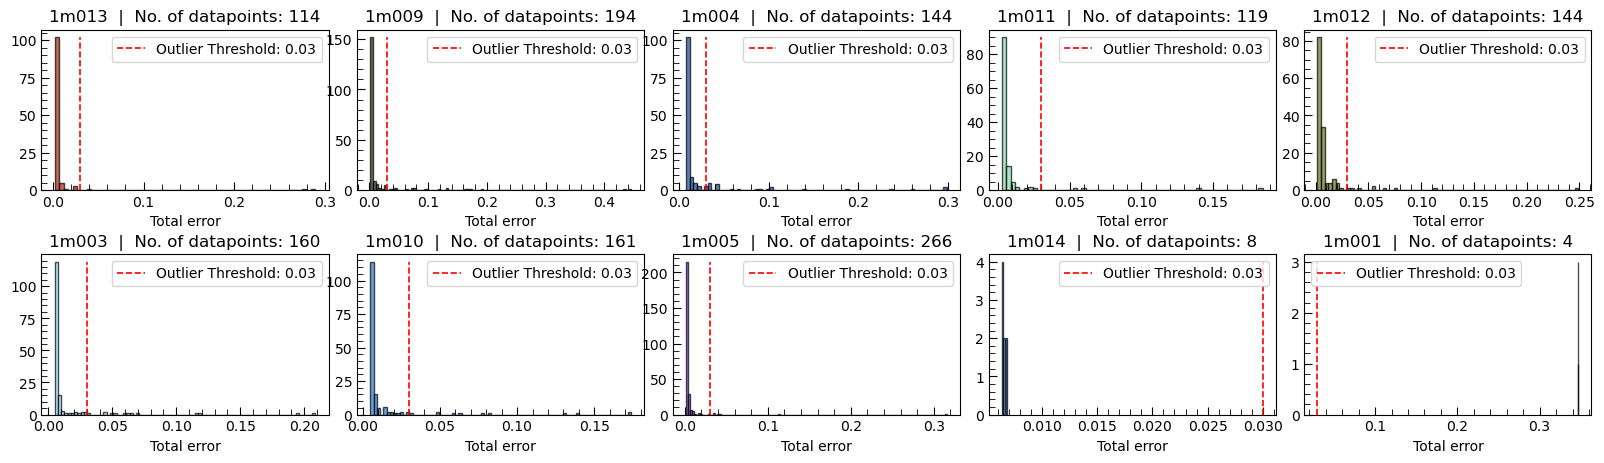

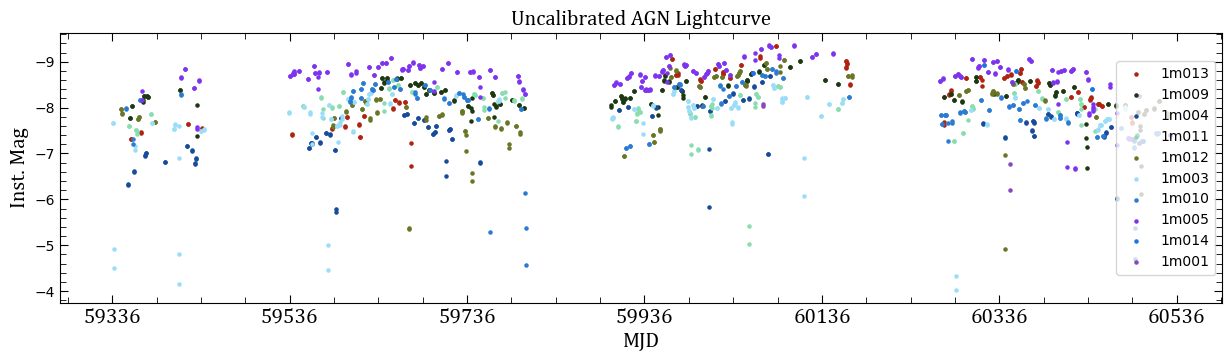

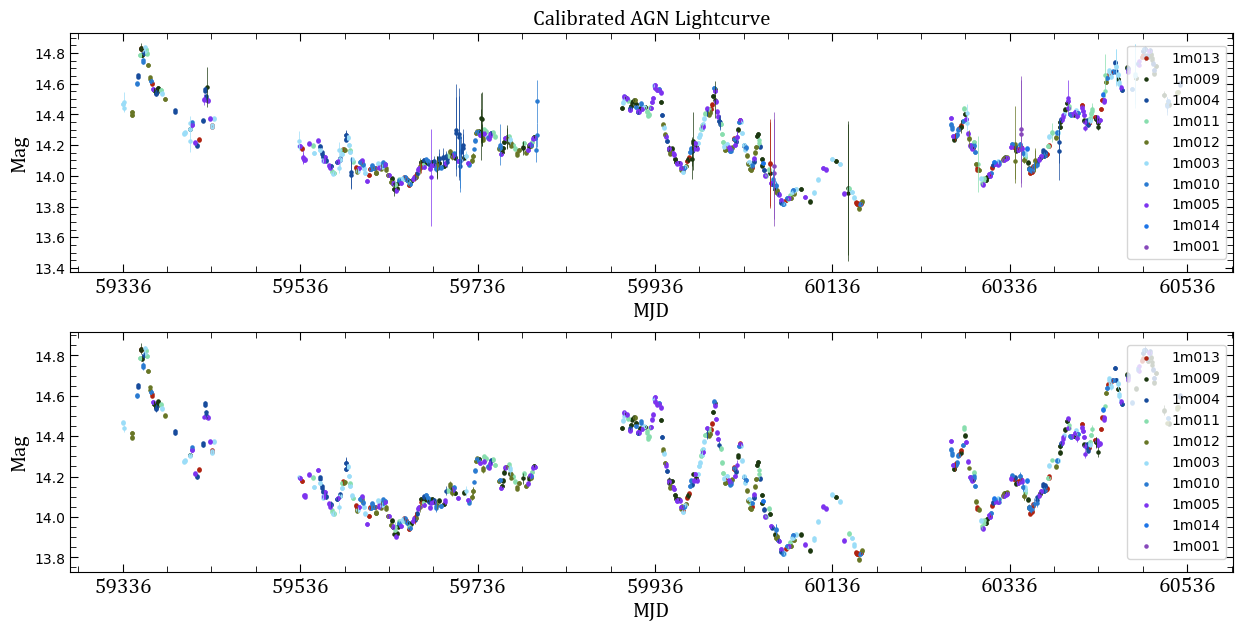

In [7]:
ZP_up = Phot_Cal(DF_up, 'up', catalogue='apass_updated.csv') #Zeropoint data
AGN_DF_up = AGN_LC(lco2, DF_up, 'up', err_th = 0.03, Plot = True, Rem_out = False, zp = ZP_up) #Calibrate AGN Lightcurve 